In [1]:
from hparams import HParams
hparams = HParams('.', name="efficient_vdvae")

Found existing ./logs-imagnet_64_baseline/hparams-imagnet_64_baseline.cfg! Resuming run using primary parameters!


In [2]:
import pickle
import numpy as np
import os
import torch
from numpy.random import seed
import random
from PIL import Image
from tqdm import tqdm

from utils.utils import assert_CUDA_and_hparams_gpus_are_equal, create_checkpoint_manager_and_load_if_exists, \
        get_logdir, get_variate_masks, transpose_dicts
from data.generic_data_loader import synth_generic_data, encode_generic_data, stats_generic_data
from data.cifar10_data_loader import synth_cifar_data, encode_cifar_data, stats_cifar_data
from data.imagenet_data_loader import synth_imagenet_data, encode_imagenet_data, stats_imagenet_data
from data.imagenet_data_loader import make_toy_filenames, train_transform, valid_transform
from data.mnist_data_loader import synth_mnist_data, encode_mnist_data, stats_mnist_data
from model.def_model import UniversalAutoEncoder
from model.model import reconstruction_step, generation_step, encode_step
from model.losses import StructureSimilarityIndexMap
from utils import temperature_functions
from model.div_stats_utils import KLDivergenceStats

from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Fix random seeds
torch.manual_seed(hparams.run.seed)
torch.manual_seed(hparams.run.seed)
torch.cuda.manual_seed(hparams.run.seed)
torch.cuda.manual_seed_all(hparams.run.seed)  # if you are using multi-GPU.
seed(hparams.run.seed)  # Numpy module.
random.seed(hparams.run.seed)  # Python random module.
torch.manual_seed(hparams.run.seed)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
# The flag below controls whether to allow TF32 on matmul. This flag defaults to True.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

2024-06-22 01:19:16.686007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 01:19:17.861168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
embeddings = pickle.load(open('logs-imagnet_64_baseline/latents/encodings_temp_first100.pkl', 'rb'))

In [4]:
embedding_size = 0
for i in embeddings['latent_codes']['image_0']:
    embedding_size += embeddings['latent_codes']['image_0'][i].size
    if i == 30:
        break
embedding_size

2610

In [5]:
device = torch.device('cuda:0')
hparams.synthesis.batch_size = 1 # 128

In [6]:
model = UniversalAutoEncoder()
model = model.to(device)
with torch.no_grad():
    ones = torch.ones((1, hparams.data.channels, hparams.data.target_res, hparams.data.target_res)).cuda(0)
    _ = model(ones)
checkpoint, checkpoint_path = create_checkpoint_manager_and_load_if_exists(rank=0)
if hparams.synthesis.load_ema_weights:
    assert checkpoint['ema_model_state_dict'] is not None
    model.load_state_dict(checkpoint['ema_model_state_dict'])
    print('EMA model is loaded')
else:
    assert checkpoint['model_state_dict'] is not None
    model.load_state_dict(checkpoint['model_state_dict'])
    print('Model Checkpoint is loaded')
print(checkpoint_path)

EMA model is loaded
./checkpoints-imagnet_64_baseline


In [7]:
def read_imagenet_images(path):
    files = [os.path.join(path, f) for f in sorted(os.listdir(path))]
    data = np.concatenate([np.load(f)['data'] for f in files], axis=0) # [samples, C * H * W]
    data = data.reshape(
        [data.shape[0], hparams.data.channels, hparams.data.target_res, hparams.data.target_res])  # [samples, C, H, W]

    data = data.transpose([0, 2, 3, 1])  # [samples, H, W, C]
    assert data.shape[1] == data.shape[2] == hparams.data.target_res
    assert data.shape[3] == hparams.data.channels

    data = shuffle(data)
    print('Number of Images:', len(data))
    print('Path: ', path)
    return data

class imagenet_dataset(torch.utils.data.Dataset):
    def __init__(self, images, mode):
        self.filenames = make_toy_filenames(images)
        self.mode = mode
        self.images = shuffle(images)

    def __getitem__(self, idx):
        if self.mode in 'train':
            img = self.images[idx]
            img = train_transform(img)
            return img

        elif self.mode in ['val', 'test', 'div_stats']:
            img = self.images[idx]
            img = valid_transform(img)
            return img

        elif self.mode == 'encode':
            img = self.images[idx]
            filename = self.filenames[idx]
            img = valid_transform(img)
            return img, filename

        else:
            raise ValueError(f'Unknown Mode {self.mode}')

    def __len__(self):
        if self.mode in ['train', 'test', 'encode']:
            return len(self.images)
        elif self.mode == 'val':
            return hparams.val.n_samples_for_validation
        elif self.mode == 'div_stats':
            return round(len(self.images) * hparams.synthesis.div_stats_subset_ratio)

In [8]:
def get_variate_masks(stats):
    thresh = np.quantile(stats, 1 - 0.03)
    return stats > thresh
div_stats = np.load('logs-imagnet_64_baseline/latents/div_stats.npy')
variate_masks = get_variate_masks(div_stats)
div_stats.shape, variate_masks.shape

((84, 32), (84, 32))

In [9]:
synth_images = read_imagenet_images(hparams.data.synthesis_data_path)
synth_images = imagenet_dataset(synth_images, mode='test')
synth_loader = torch.utils.data.DataLoader(
    dataset=synth_images,
    batch_size=hparams.synthesis.batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=hparams.run.num_cpus,
    drop_last=True)

Number of Images: 50000
Path:  ../datasets/imagenet_64/val_data/


In [10]:
# for step, inputs in enumerate(synth_loader):
#     inputs = inputs.to(device)
#     if step == 0:
#         break

In [11]:
# # Assuming synth_loader is already defined and you've iterated through it
# # To reset and start from the first data point again
# iterator = iter(synth_loader)
# inputs = next(iterator)
inputs = next(iter(synth_loader)).to(device)
inputs.shape

torch.Size([1, 3, 64, 64])

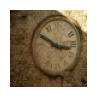

In [12]:
model.eval()
with torch.no_grad():
    predictions, posterior_dist_list, prior_kl_dist_list = model(inputs, variate_masks)
outputs = model.top_down.sample(predictions)
# Plot the sample_from_latent variable
image = outputs[0].detach().cpu().numpy()
image = np.round(image * 127.5 + 127.5)
image = image.astype(np.uint8)
image = np.transpose(image, (1, 2, 0))
plt.figure(figsize=(1, 1))
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
len(posterior_dist_list), len(embeddings['latent_codes']['image_0'])

(84, 68)

In [14]:
# for i in range(len(embeddings['latent_codes']['image_0'])):
#     print(embeddings['latent_codes']['image_0'][i].shape)
# embeddings['latent_codes']['image_0']

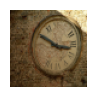

In [15]:
image = embeddings['images']['image_0']
image = np.round(image * 127.5 + 127.5)
image = image.astype(np.uint8)
image = np.transpose(image, (1, 2, 0))
plt.figure(figsize=(1, 1))
plt.imshow(image)
plt.axis('off')
plt.show()

In [16]:
len(variate_masks), sum(hparams.model.down_n_blocks_per_res), len(hparams.model.down_strides)

(84, 31, 53)

In [17]:
skip_list = model.bottom_up(inputs)

In [18]:
len(skip_list), sum([x.detach().cpu().numpy().size for x in skip_list]), skip_list[50].detach().cpu().numpy().size

(53, 20540416, 2097152)

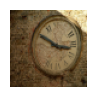

torch.Size([1, 100, 64, 64])

In [19]:
outputs_y, posterior_dist_list, prior_kl_dist_list = model.top_down(skip_list, variate_masks=variate_masks)
outputs = model.top_down.sample(outputs_y)
# Plot the sample_from_latent variable
image = outputs[0].detach().cpu().numpy()
image = np.round(image * 127.5 + 127.5)
image = image.astype(np.uint8)
image = np.transpose(image, (1, 2, 0))
plt.figure(figsize=(1, 1))
plt.imshow(image)
plt.axis('off')
plt.show()
outputs_y.shape

In [56]:
def reshape_distribution(dist_list, variate_mask):
    """
    :param dist_list: n_layers, 2*  [ batch_size n_variates, H , W]
    :return: Tensors  of shape batch_size, H, W ,n_variates, 2
    H, W , n_variates will be different from each other in the list depending on which layer you are in.
    """
    dist = torch.stack(dist_list, dim=0)  # 2, batch_size, n_variates, H ,W
    dist = dist[:, :, variate_mask, :, :]  # Only take effective variates
    dist = torch.permute(dist, (1, 3, 4, 2, 0))  # batch_size, H ,W ,n_variates (subset), 2
    # dist = torch.unbind(dist, dim=0)  # Return a list of tensors of length batch_size
    return dist

In [57]:
@torch.jit.script
def calculate_z(mean, std):
    eps = torch.empty_like(mean, device=torch.device('cuda')).normal_(0., 1.)
    z = eps * std + mean
    return z, mean, std

In [58]:
skip_list = model.bottom_up(torch.ones((1, 3, 64, 64)).cuda(0))

In [112]:
def get_variate_masks(stats):
    thresh = np.quantile(stats, 1 - 0.03)
    return stats > thresh
div_stats = np.load('logs-imagnet_64_baseline/latents/div_stats.npy')
variate_masks = get_variate_masks(div_stats)
div_stats.shape, variate_masks.shape

((84, 32), (84, 32))

In [123]:
embeddings = pickle.load(open('logs-imagnet_64_baseline/latents/encodings_temp_first100_003.pkl', 'rb'))
embedding = embeddings['latent_codes']['image_0']
embedding_size = 0
for i in embedding.keys():
    embedding_size += embedding[i].size
    if i > 30:
        break
embedding_size

2738

In [124]:
y = torch.tile(model.top_down.trainable_h, (skip_list[0].size()[0], 1, 1, 1))
y.shape, model.top_down.trainable_h.shape

(torch.Size([1, 512, 1, 1]), torch.Size([1, 512, 1, 1]))

In [125]:
torch.manual_seed(hparams.run.seed)
torch.cuda.manual_seed(hparams.run.seed)
layer_idx = 0
posterior_dist_list = []
for i, (level_down_upsample, level_down, skip_input) in enumerate(
        zip(model.top_down.levels_down_upsample, model.top_down.levels_down, skip_list)):
    # print('Layer:', i, 'Layer Index:', layer_idx)
    try:
        posterior_dist_i = torch.Tensor(embedding[layer_idx]).cuda(0)
        mean, std = torch.chunk(torch.permute(posterior_dist_i, (3, 2, 0, 1)), chunks=2, dim=0)
        # z, mean, std = calculate_z(mean, std)
        z = mean
        if i > 30:
            z = torch.zeros_like(mean).cuda(0)
    except KeyError:
        print('Key Error:', layer_idx)
        z = None
    y, posterior_dist, prior_kl_dist, = level_down_upsample(skip_input, y, variate_mask=variate_masks[layer_idx], z=z)
    # y, posterior_dist, prior_kl_dist, = level_down_upsample(skip_input, y, variate_mask=variate_masks[layer_idx])
    layer_idx += 1
    resolution_posterior_dist = [posterior_dist]
    resolution_prior_kl_dist = [prior_kl_dist]

    for j, layer in enumerate(level_down):
        # print('layer:', i, 'layer Index:', layer_idx)
        try:
            posterior_dist_i = torch.Tensor(embedding[layer_idx]).cuda(0)
            mean, std = torch.chunk(torch.permute(posterior_dist_i, (3, 2, 0, 1)), chunks=2, dim=0)
            # z, mean, std = calculate_z(mean, std)
            z = mean
            if i > 30:
                z = torch.zeros_like(mean).cuda(0)
        except KeyError:
            print('Key Error:', layer_idx)
            z = None
        y, posterior_dist, prior_kl_dist = layer(skip_input, y, variate_mask=variate_masks[layer_idx], z=z)
        # y, posterior_dist, prior_kl_dist = layer(skip_input, y, variate_mask=variate_masks[layer_idx])
        layer_idx += 1

        resolution_posterior_dist.append(posterior_dist)
        resolution_prior_kl_dist.append(prior_kl_dist)

    posterior_dist_list += resolution_posterior_dist
    prior_kl_dist_list += resolution_prior_kl_dist
    # if i == 48:
    #     break
predictions = model.top_down.output_conv(y)

Key Error: 13
Key Error: 21
Key Error: 23
Key Error: 28
Key Error: 29
Key Error: 32
Key Error: 33
Key Error: 34
Key Error: 35
Key Error: 54
Key Error: 55
Key Error: 57
Key Error: 73
Key Error: 75
Key Error: 78
Key Error: 83


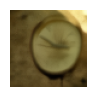

In [126]:
# model.eval()
# with torch.no_grad():
#     predictions, posterior_dist_list, prior_kl_dist_list = model(inputs, variate_masks)
outputs = model.top_down.sample(predictions)
# Plot the sample_from_latent variable
image = outputs[0].detach().cpu().numpy()
image = np.round(image * 127.5 + 127.5)
image = image.astype(np.uint8)
image = np.transpose(image, (1, 2, 0))
plt.figure(figsize=(1, 1))
plt.imshow(image)
plt.axis('off')
plt.show()

In [120]:
# reshape_distribution(posterior_dist, variate_masks[layer_idx])
# reshape_distribution(posterior_dist, variate_masks[1])
# reshape_distribution(posterior_dist_list[1], variate_masks[1])
reshape_distribution(posterior_dist_list[0], variate_masks[0])

tensor([[[[[2.8285, 0.2858],
           [6.6891, 0.2627]]]]], device='cuda:0', grad_fn=<PermuteBackward0>)

In [121]:
# embeddings['latent_codes']['image_0'][1]
embeddings['latent_codes']['image_0'][0]

array([[[[2.8292532 , 0.28566203],
         [6.687244  , 0.26273352]]]], dtype=float32)

In [57]:
posterior_dist_list[1][0].shape

torch.Size([1, 32, 1, 1])

In [44]:
y.shape

torch.Size([1, 512, 1, 1])

In [21]:
y = model.top_down.output_conv(y)
y.shape

torch.Size([1, 100, 64, 64])

In [23]:
# for i in range(50):
#     print(model.top_down.levels_down_upsample[i].strides)

In [170]:
y = torch.tile(model.top_down.trainable_h, (skip_list[0].size()[0], 1, 1, 1))
y.shape, model.top_down.trainable_h.shape

(torch.Size([1, 512, 1, 1]), torch.Size([1, 512, 1, 1]))

In [171]:
torch.manual_seed(hparams.run.seed)
torch.cuda.manual_seed(hparams.run.seed)
level_down_upsample = model.top_down.levels_down_upsample[0]
skip_input = skip_list[0]
variate_mask = variate_masks[0]
if level_down_upsample.strides > 1:
    y = level_down_upsample.unpool(y)

In [172]:
y_prior_kl = level_down_upsample.prior_net(y)
y_prior_kl.shape

torch.Size([1, 1024, 1, 1])

In [173]:
kl_residual, y_prior_kl = torch.chunk(y_prior_kl, chunks=2, dim=1)  # B, C, H, W
kl_residual.shape, y_prior_kl.shape

(torch.Size([1, 512, 1, 1]), torch.Size([1, 512, 1, 1]))

In [174]:
y_post = torch.cat([y, skip_input], dim=1)
print(y_post.shape)
y_post = level_down_upsample.posterior_net(y_post)
print(y_post.shape)

torch.Size([1, 1024, 1, 1])
torch.Size([1, 512, 1, 1])


In [175]:
z_prior_kl, prior_kl_dist = level_down_upsample.sampler(level_down_upsample.prior_layer, y_prior_kl)
z_prior_kl.shape, len(prior_kl_dist), prior_kl_dist[0].shape, prior_kl_dist[1].shape

(torch.Size([1, 32, 1, 1]),
 2,
 torch.Size([1, 32, 1, 1]),
 torch.Size([1, 32, 1, 1]))

In [176]:
hparams.model.use_residual_distribution

False

In [181]:
torch.Tensor(embeddings['latent_codes']['image_0'][0]).shape

torch.Size([1, 1, 2, 2])

In [ ]:
dist = torch.stack(dist_list, dim=0)  # 2, batch_size, n_variates, H ,W
dist = dist[:, :, variate_mask, :, :]  # Only take effective variates
dist = torch.permute(dist, (1, 3, 4, 2, 0))  # batch_size, H ,W ,n_variates (subset), 2

In [204]:
torch.Tensor(embeddings['latent_codes']['image_0'][0]).cuda().shape

torch.Size([1, 1, 2, 2])

In [208]:
torch.permute(torch.Tensor(embeddings['latent_codes']['image_0'][0]).cuda(), (3, 2, 0, 1)).shape

torch.Size([2, 2, 1, 1])

In [210]:
# mean, std = torch.chunk(torch.Tensor(embeddings['latent_codes']['image_0'][0]).cuda(), chunks=2, dim=3)
mean, std = torch.chunk(torch.permute(torch.Tensor(embeddings['latent_codes']['image_0'][0]).cuda(), (3, 2, 0, 1)), chunks=2, dim=0)
mean, std

(tensor([[[[2.8293]],
 
          [[6.6872]]]], device='cuda:0'),
 tensor([[[[0.2857]],
 
          [[0.2627]]]], device='cuda:0'))

In [211]:
@torch.jit.script
def calculate_z(mean, std):
    eps = torch.empty_like(mean, device=torch.device('cuda')).normal_(0., 1.)
    z = eps * std + mean
    return z, mean, std
torch.manual_seed(hparams.run.seed)
torch.cuda.manual_seed(hparams.run.seed)
z, mean, std = calculate_z(mean, std)
z

tensor([[[[2.3552]],

         [[7.1938]]]], device='cuda:0')

In [212]:
variate_mask2 = torch.Tensor(variate_mask)[None, :, None, None].cuda()

In [213]:
z_post = (1. - variate_mask2) * z_prior_kl

In [214]:
z_post.shape, z.shape

(torch.Size([1, 32, 1, 1]), torch.Size([1, 2, 1, 1]))

In [215]:
z_post[:, variate_mask, :, :] = z

In [144]:
# Samples posterior under expected value of q(z<i|x)
z_post, posterior_dist = level_down_upsample.sampler(
    level_down_upsample.posterior_layer,
    y_post,
    prior_stats=prior_kl_dist if hparams.model.use_residual_distribution else None)

In [145]:
z_post.shape, len(posterior_dist), posterior_dist[0].shape, posterior_dist[1].shape

(torch.Size([1, 32, 1, 1]),
 2,
 torch.Size([1, 32, 1, 1]),
 torch.Size([1, 32, 1, 1]))

In [146]:
reshape_distribution(posterior_dist, variate_mask), reshape_distribution(posterior_dist, variate_mask).shape

(tensor([[[[[2.8285, 0.2858],
            [6.6891, 0.2627]]]]], device='cuda:0', grad_fn=<PermuteBackward0>),
 torch.Size([1, 1, 1, 2, 2]))

In [153]:
reshape_distribution([z_post], variate_mask), reshape_distribution([z_post], variate_mask).shape

(tensor([[[[[2.8605],
            [6.6652]]]]], device='cuda:0', grad_fn=<PermuteBackward0>),
 torch.Size([1, 1, 1, 2, 1]))

In [166]:
torch.stack([z_post], dim=0)[:, :, variate_mask, :, :].shape

torch.Size([1, 1, 2, 1, 1])

In [158]:
variate_mask

array([False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [148]:
embeddings['latent_codes']['image_0'][0]

array([[[[2.8292532 , 0.28566203],
         [6.687244  , 0.26273352]]]], dtype=float32)

In [149]:
variate_mask2 = torch.Tensor(variate_mask)[None, :, None, None].cuda()

In [150]:
variate_mask.shape, variate_mask2.shape

((32,), torch.Size([1, 32, 1, 1]))

In [152]:
(variate_mask2 * z_post).shape

torch.Size([1, 32, 1, 1])

In [34]:
z_post = variate_mask2 * z_post + (1. - variate_mask2) * z_prior_kl
z_post.shape

torch.Size([1, 32, 1, 1])

In [169]:
z_post = z_priaior_kl
z_post[:, varte_mask, :, :].shape

torch.Size([1, 2, 1, 1])

In [35]:
# Residual with prior
y = y + kl_residual

# Project z and merge back into main stream
z_post = level_down_upsample.z_projection(z_post)
y = y + z_post

# Residual block
y = level_down_upsample.residual_block(y)

In [36]:
y.shape

torch.Size([1, 512, 1, 1])